In [1]:
import os, warnings, random
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # reduce TF backend logs

In [2]:
# 1) Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import joblib
from pathlib import Path
from tqdm import tqdm

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

C:\Users\soura\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2) Load dataset
# =====================================================
df = pd.read_excel("DPPH Scavenging percentage for L81.xlsx")
target_col = "DPPH Scavenging activity %"
exclude_cols = [target_col, "Sl No.", "Sl No", "S.No", "S No", "Index"]

In [4]:
# 3) Clean and prepare
# =====================================================
feature_cols = [
    c for c in df.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
]
if not feature_cols:
    raise ValueError("No numeric feature columns found. Check exclude_cols and your Excel data.")

df_clean = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_clean[feature_cols].values.astype(float)
y = df_clean[target_col].values.astype(float)

print(f"Rows after cleaning: {len(df_clean)}")
print(f"# Features: {len(feature_cols)}")
print("First 5 feature names:", feature_cols[:5])

Rows after cleaning: 243
# Features: 10
First 5 feature names: ['Tryptone (g/L)', 'Peptone(g/L)', 'Glucose   (g/L)', 'Yeast extract (g/L)', 'K2HPO4(g/L)']


In [5]:
# 4) Scale
# =====================================================
scaler_nn = StandardScaler()
X_scaled = scaler_nn.fit_transform(X)

In [6]:
# 5) NN model
# =====================================================
def build_nn(input_dim, l2=1e-4, dropout_rate=0.15):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout_rate*0.75),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [7]:
# 6) 5-Fold CV
# =====================================================
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    model = build_nn(X_scaled.shape[1])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=0)

    model.fit(
        X_tr, y_tr/100.0,
        validation_data=(X_val, y_val/100.0),
        epochs=300, batch_size=8, callbacks=[es], verbose=0
    )

    y_pred_val = (model.predict(X_val, verbose=0).flatten() * 100.0)
    r2  = r2_score(y_val, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae = mean_absolute_error(y_val, y_pred_val)
    cv_scores.append({'fold': fold, 'r2': r2, 'rmse': rmse, 'mae': mae})

cv_df = pd.DataFrame(cv_scores)
print("\nCV summary → R2: {:.4f} ± {:.4f}, RMSE: {:.3f} ± {:.3f}, MAE: {:.3f} ± {:.3f}".format(
    cv_df['r2'].mean(), cv_df['r2'].std(),
    cv_df['rmse'].mean(), cv_df['rmse'].std(),
    cv_df['mae'].mean(), cv_df['mae'].std()
))
display(cv_df)


CV summary → R2: 0.9436 ± 0.0412, RMSE: 2.957 ± 1.222, MAE: 2.142 ± 0.697


,fold,r2,rmse,mae
0,1,0.979579,2.021358,1.636855
1,2,0.902074,3.805005,2.747727
2,3,0.977534,2.024290,1.501768
3,4,0.962468,2.244032,1.795280
4,5,0.896130,4.687999,3.029915


In [8]:
# 7) Final NN training
# =====================================================
X_tr_full, X_test_full, y_tr_full, y_test_full = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED
)

nn_final = build_nn(X_scaled.shape[1])
es = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=0)

history_final = nn_final.fit(
    X_tr_full, y_tr_full/100.0,
    validation_split=0.15,
    epochs=400, batch_size=8, callbacks=[es], verbose=0
)

y_pred_nn_test = (nn_final.predict(X_test_full, verbose=0).flatten() * 100.0)
r2_nn  = r2_score(y_test_full, y_pred_nn_test)
rmse_nn = np.sqrt(mean_squared_error(y_test_full, y_pred_nn_test))
mae_nn  = mean_absolute_error(y_test_full, y_pred_nn_test)
print(f"\nHoldout → R2={r2_nn:.4f}, RMSE={rmse_nn:.3f}, MAE={mae_nn:.3f}")


Holdout → R2=0.9702, RMSE=2.443, MAE=2.002


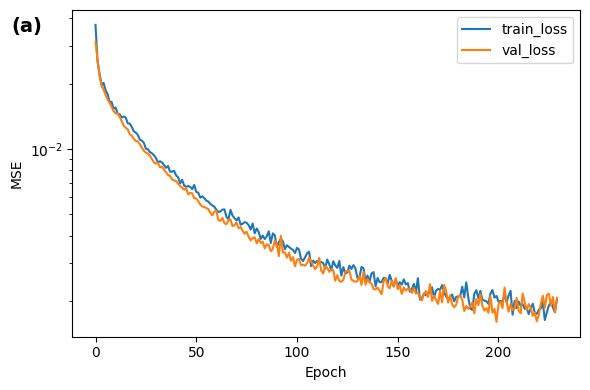

In [9]:
# Training history plot (Figure 4)
plt.figure(figsize=(6,4))
plt.plot(history_final.history['loss'], label='train_loss')
plt.plot(history_final.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Panel label (a) – closer to inside-top-left
plt.text(-0.12, 0.98, "(a)", transform=plt.gca().transAxes,
         fontsize=14, fontweight="bold", va="top", ha="left")

plt.tight_layout()
plt.savefig("nn_training_history.png", dpi=300, bbox_inches="tight")
plt.show()

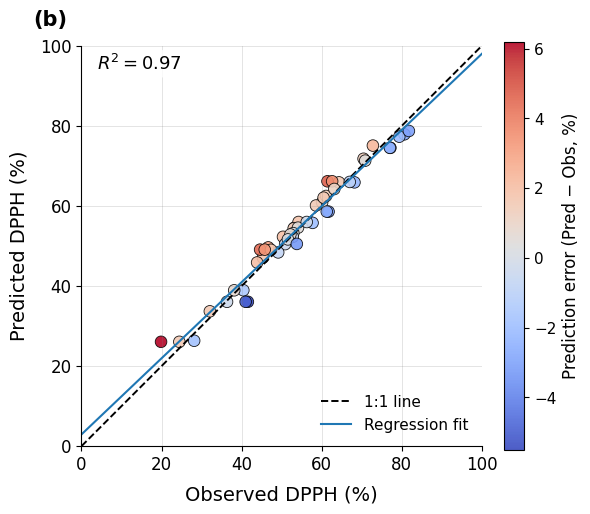

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Compute error and R²
errors = y_pred_nn_test - y_test_full
r2 = r2_score(y_test_full, y_pred_nn_test)

fig, ax = plt.subplots(figsize=(6, 6))

# Scatter: color by error
sc = ax.scatter(
    y_test_full,
    y_pred_nn_test,
    c=errors,
    cmap="coolwarm",         # colormap representing prediction error magnitude
    s=70,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.9
)

# 1:1 line
ax.plot([0, 100], [0, 100],
        linestyle="--", color="black", linewidth=1.4, label="1:1 line")

# Regression line
m, b = np.polyfit(y_test_full, y_pred_nn_test, 1)
ax.plot(
    [0, 100],
    m * np.array([0, 100]) + b,
    color="#1f77b4",
    linewidth=1.5,
    label="Regression fit"
)

# Axes labels
ax.set_xlabel("Observed DPPH (%)", fontsize=14, labelpad=8)
ax.set_ylabel("Predicted DPPH (%)", fontsize=14, labelpad=8)

# Limits and aspect
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect("equal", adjustable="box")

# Ticks
ax.tick_params(axis="both", which="major", labelsize=12)

# Remove top/right spines for clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Light grid
ax.grid(axis="both", color="grey", alpha=0.25, linewidth=0.6)

# Colorbar (error scale) — moved right to prevent overlap
cbar = plt.colorbar(sc, ax=ax, pad=0.05, fraction=0.046)
cbar.set_label("Prediction error (Pred − Obs, %)", fontsize=12)
cbar.ax.tick_params(labelsize=11)

# R² text (box)
ax.text(
    0.04, 0.94,
    f"$R^2 = {r2:.2f}$",
    transform=ax.transAxes,
    fontsize=13,
    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="none")
)

# Panel label (b)
ax.text(
    -0.12, 1.05, "(b)",
    transform=ax.transAxes,
    fontsize=15,
    fontweight="bold"
)

# Legend
ax.legend(frameon=False, fontsize=11, loc="lower right")

fig.tight_layout()
fig.savefig("colorful_highimpact_modified.png", dpi=600, bbox_inches="tight")
plt.show()


In [11]:
# 10) GA optimization with NN surrogate
# =====================================================
feature_levels = {}
for c in feature_cols:
    vals = pd.unique(df_clean[c].dropna())
    vals = [float(v) for v in vals]
    vals = sorted(vals)
    if not vals:
        raise ValueError(f"No valid levels for feature '{c}'.")
    feature_levels[c] = vals

def nn_predict_from_ind(ind):
    df_in = pd.DataFrame([ind], columns=feature_cols)
    x_scaled = scaler_nn.transform(df_in.values.astype(float))
    return float(nn_final.predict(x_scaled, verbose=0).flatten()[0] * 100.0)

POP_NN, GEN_NN, MUT_RATE_NN = 150, 200, 0.15
def random_individual():
    return [random.choice(feature_levels[f]) for f in feature_cols]

population = [random_individual() for _ in range(POP_NN)]
best_overall = None
history_nn = []

bar = tqdm(range(GEN_NN), desc="GA generations", leave=False, mininterval=0.5)
for gen in bar:
    scored = [(ind, nn_predict_from_ind(ind)) for ind in population]
    scored.sort(key=lambda x: x[1], reverse=True)

    if (best_overall is None) or (scored[0][1] > best_overall[1]):
        best_overall = (scored[0][0], scored[0][1], gen)

    history_nn.append(scored[0][1])
    bar.set_postfix(best=f"{history_nn[-1]:.2f}%")

    cutoff = max(2, int(0.25 * POP_NN))
    selected = [ind for ind, _ in scored[:cutoff]]
    newpop = selected.copy()
    while len(newpop) < POP_NN:
        a, b = random.sample(selected, 2)
        pt = random.randint(1, len(feature_cols)-1)
        child = a[:pt] + b[pt:]
        if random.random() < MUT_RATE_NN:
            mi = random.randrange(len(feature_cols))
            child[mi] = random.choice(feature_levels[feature_cols[mi]])
        newpop.append(child)
    population = newpop

best_combo_nn = dict(zip(feature_cols, best_overall[0]))
best_score = float(best_overall[1])
print("\nGA result:")
print("  Best predicted DPPH: {:.2f}%".format(min(best_score, 100.0)))
print("  Generation found    :", best_overall[2])
print("  Best combo (feature → value):")
for k, v in best_combo_nn.items():
    print(f"    {k}: {v}")


GA result:
  Best predicted DPPH: 83.79%
  Generation found    : 3
  Best combo (feature → value):
    Tryptone (g/L): 3.0
    Peptone(g/L): 2.0
    Glucose   (g/L): 2.0
    Yeast extract (g/L): 1.0
    K2HPO4(g/L): 0.2
    NaCl (g/L): 5.0
    Streptomycin (g/L): 0.75
    Beef Extract  (g/L): 3.0
    PH: 6.0
    Temperature (oC): 25.0


In [13]:
# =====================================================
# After GA loop → pick Top 5
# =====================================================
final_scored = [(ind, nn_predict_from_ind(ind)) for ind in population]
final_scored.sort(key=lambda x: x[1], reverse=True)

# Take top 5 unique solutions
top5 = []
seen = set()
for ind, score in final_scored:
    key = tuple(ind)
    if key not in seen:
        seen.add(key)
        top5.append((ind, score))
    if len(top5) >= 5:
        break

print("\nTop 5 GA-predicted optimal combinations:")
for rank, (ind, score) in enumerate(top5, 1):
    print(f"\nOption {rank}: Predicted DPPH = {score:.2f}%")
    for k, v in zip(feature_cols, ind):
        print(f"   {k}: {v}")

# (Optional) Save to Excel
df_top5 = pd.DataFrame([dict(zip(feature_cols, ind)) | {"Predicted DPPH (%)": score}
                        for ind, score in top5])
df_top5.to_excel("Top5_GA_Optimal_Recipes.xlsx", index=False)
print("\nSaved Top 5 results → Top5_GA_Optimal_Recipes.xlsx")


Top 5 GA-predicted optimal combinations:

Option 1: Predicted DPPH = 83.79%
   Tryptone (g/L): 3.0
   Peptone(g/L): 2.0
   Glucose   (g/L): 2.0
   Yeast extract (g/L): 1.0
   K2HPO4(g/L): 0.2
   NaCl (g/L): 5.0
   Streptomycin (g/L): 0.75
   Beef Extract  (g/L): 3.0
   PH: 6.0
   Temperature (oC): 25.0

Option 2: Predicted DPPH = 83.23%
   Tryptone (g/L): 3.0
   Peptone(g/L): 2.0
   Glucose   (g/L): 2.0
   Yeast extract (g/L): 1.0
   K2HPO4(g/L): 0.2
   NaCl (g/L): 5.0
   Streptomycin (g/L): 0.75
   Beef Extract  (g/L): 3.0
   PH: 7.0
   Temperature (oC): 25.0

Option 3: Predicted DPPH = 82.81%
   Tryptone (g/L): 5.0
   Peptone(g/L): 2.0
   Glucose   (g/L): 2.0
   Yeast extract (g/L): 1.0
   K2HPO4(g/L): 0.2
   NaCl (g/L): 5.0
   Streptomycin (g/L): 0.75
   Beef Extract  (g/L): 3.0
   PH: 6.0
   Temperature (oC): 25.0

Option 4: Predicted DPPH = 81.01%
   Tryptone (g/L): 3.0
   Peptone(g/L): 2.0
   Glucose   (g/L): 1.0
   Yeast extract (g/L): 1.0
   K2HPO4(g/L): 0.2
   NaCl (g/L): 5.0

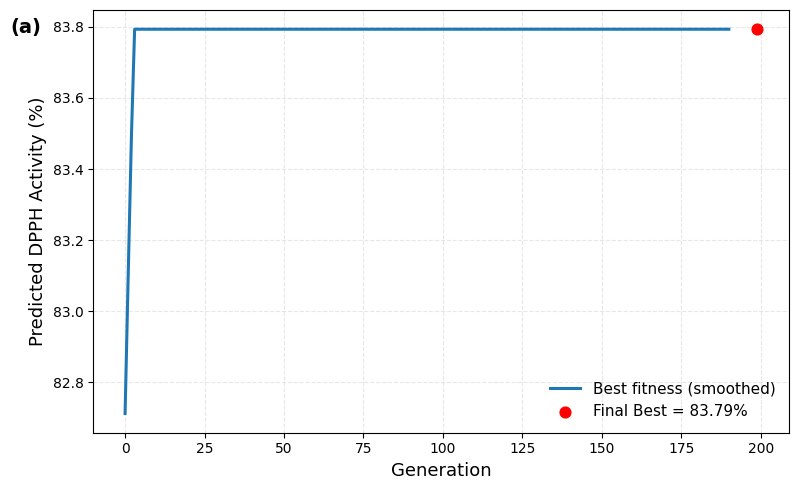

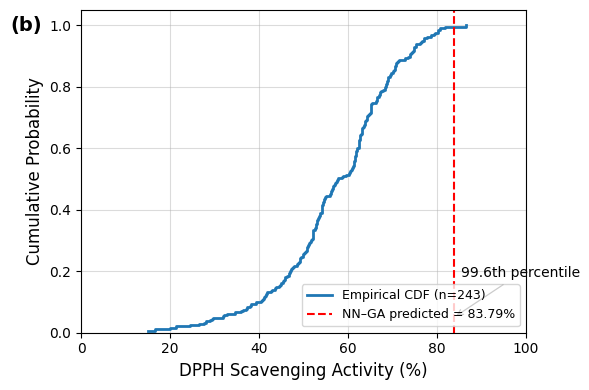

In [14]:
# =====================================================
# Plot GA Convergence and Empirical CDF
# =====================================================
import matplotlib.pyplot as plt
import numpy as np

# ---- GA Convergence ----
gens = np.arange(len(history_nn))
best_per_gen = history_nn
window = 10
best_smooth = (
    np.convolve(best_per_gen, np.ones(window)/window, mode='valid')
    if len(best_per_gen) >= window else np.array(best_per_gen)
)

plt.figure(figsize=(8, 5))
plt.plot(gens[:len(best_smooth)], best_smooth, color="#1f77b4", linewidth=2.2,
         label="Best fitness (smoothed)")
plt.scatter(len(best_per_gen) - 1, best_per_gen[-1], color="red", s=60, zorder=5,
            label=f"Final Best = {best_per_gen[-1]:.2f}%")

plt.text(-0.12, 0.98, "(a)", transform=plt.gca().transAxes,
         fontsize=14, fontweight="bold", va="top", ha="left")
plt.xlabel("Generation", fontsize=13)
plt.ylabel("Predicted DPPH Activity (%)", fontsize=13)
plt.legend(fontsize=11, loc="lower right", frameon=False)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("GA_Convergence.png", dpi=600, bbox_inches="tight")
plt.show()


# ---- Empirical CDF ----
y_array = np.asarray(y, dtype=float)
y_array = y_array[np.isfinite(y_array)]
sorted_y = np.sort(y_array)
n = len(sorted_y)
ecdf = np.arange(1, n + 1) / n

predicted_value = float(np.clip(best_score, 0.0, 100.0))
pct = np.searchsorted(sorted_y, predicted_value, side="right") / n * 100

plt.figure(figsize=(6, 4))
plt.step(sorted_y, ecdf, where='post', linewidth=2, label=f'Empirical CDF (n={n})')
plt.axvline(predicted_value, color='red', linestyle='--', linewidth=1.5,
            label=f'NN–GA predicted = {predicted_value:.2f}%')

plt.annotate(f'{pct:.1f}th percentile',
             xy=(predicted_value, 0.05),
             xytext=(predicted_value + 1.5, 0.18),
             arrowprops=dict(arrowstyle='->', linewidth=0.9),
             fontsize=10)

plt.text(-0.16, 0.98, "(b)", transform=plt.gca().transAxes,
         fontsize=14, fontweight="bold", va="top", ha="left")
plt.xlabel('DPPH Scavenging Activity (%)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, 1.05)
plt.grid(alpha=0.45)
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.savefig('CDF_pub.png', dpi=600, bbox_inches="tight")
plt.show()